# DIMENSIONALITY REDUCTION: PCA

### ¿WHAT IT IS?
PCA (Principal Component Analysis) is a Machine Learning algorithm very powerful which has varying applications in Data Science, ranging from visualization, compression to later applied another ML algorithm.

Suppose that we have a collection of $m$ points $\{x^{(1)},...,x^{(m)}\}$ in $\mathbb{R}^{n}$, each one with several attributes. We would like to reduce the attributes (compress) with the minimum precision lost. This is achieved by creating new attributes that describe our points with less information.

Mathematically speaking, given a point $x^{i} \in \mathbb{R}^{n}$ we will find a corresponding vector $c^{i} \in \mathbb{R}^{l}$, with $n < l$.

This could also be described like a change of coordinates, onto which we project our points like [this post](http://mengnote.blogspot.com/2013/05/an-intuitive-explanation-of-pca.html) explains. ![Explanation of PCA](http://4.bp.blogspot.com/-pleL0HvLUgU/UYqpNFdd8EI/AAAAAAAAAHA/uf11u9lcq5g/s1600/PCA_1.png)

<br>
<br>
<br>
<br>
###  General explanation of notebook
The structure of the notebook is getting all the data we will use, visualize it, perform PCA on the data with the scikit-learn package, to have an overview of the final result, explain more in-depth the algorithm and create our own function that performs PCA for later compare it with the scikit-learn one.

### 1. Getting the data
First of all, we have to import all of the dependencies that we will later use and the dataset we will perform PCA on. 

In [1]:
import numpy as np #library to work with vectors and matrix
import matplotlib.pyplot as plt #library to work with graphics and plots

%matplotlib inline


We have chosen the MNIST dataset, a very famous dataset for beginners, which contains images of handwritten digits (0 to 9). So we have to download (or load from the computer) the dataset and assign it to vectors.

In [2]:
def mnist(path=None):
    r"""Return (train_images, train_labels, test_images, test_labels).

    Args:
        path (str): Directory containing MNIST. Default is
            /home/USER/data/mnist or C:\Users\USER\data\mnist.
            Create if nonexistant. Download any missing files.

    Returns:
        Tuple of (train_images, train_labels, test_images, test_labels), each
            a matrix. Rows are examples. Columns of images are pixel values.
            Columns of labels are a onehot encoding of the correct class.
    """
    #Taken from: 'https://mattpetersen.github.io/load-mnist-with-numpy'
    import gzip
    import os
    from urllib.request import urlretrieve

    url = 'http://yann.lecun.com/exdb/mnist/'
    files = ['train-images-idx3-ubyte.gz',
             'train-labels-idx1-ubyte.gz',
             't10k-images-idx3-ubyte.gz',
             't10k-labels-idx1-ubyte.gz']

    if path is None:
        # Set path to /home/USER/data/mnist or C:\Users\USER\data\mnist
        path = os.path.join(os.path.expanduser('~'), 'data', 'mnist')

    # Create path if it doesn't exist
    os.makedirs(path, exist_ok=True)

    # Download any missing files
    for file in files:
        if file not in os.listdir(path):
            urlretrieve(url + file, os.path.join(path, file))
            print("Downloaded %s to %s" % (file, path))

    def _images(path):
        """Return images loaded locally."""
        with gzip.open(path) as f:
            # First 16 bytes are magic_number, n_imgs, n_rows, n_cols
            pixels = np.frombuffer(f.read(), 'B', offset=16)
        return pixels.reshape(-1, 784).astype('float32') / 255

    def _labels(path):
        """Return labels loaded locally."""
        with gzip.open(path) as f:
            # First 8 bytes are magic_number, n_labels
            integer_labels = np.frombuffer(f.read(), 'B', offset=8)

        def _onehot(integer_labels):
            """Return matrix whose rows are onehot encodings of integers."""
            n_rows = len(integer_labels)
            n_cols = integer_labels.max() + 1
            onehot = np.zeros((n_rows, n_cols), dtype='uint8')
            onehot[np.arange(n_rows), integer_labels] = 1
            return onehot

        return _onehot(integer_labels)

    train_images = _images(os.path.join(path, files[0]))
    train_labels = _labels(os.path.join(path, files[1]))
    test_images = _images(os.path.join(path, files[2]))
    test_labels = _labels(os.path.join(path, files[3]))

    return train_images, train_labels, test_images, test_labels

In [3]:
train_images, train_labels, test_images, test_labels = mnist("../datasets/MNIST")

The labels of the dataset are encoded like a one hot vector, this is a vector with zeros in all the entries except a one on the i-th entry. We have to transform this encoding to the categorical labels. An example:
$(0,0,1,0,0,0,0,0,0,0) \mapsto 3$.

In [4]:
def from_one_hot_to_vector(labels):
    return np.argmax(labels, axis=1)

In [5]:
print("One-hot encoding: {}".format(train_labels[0]))
train_labels = from_one_hot_to_vector(train_labels)
print("Categorical encoding: {}".format(train_labels[0]))
test_labels = from_one_hot_to_vector(test_labels)

One-hot encoding: [0 0 0 0 0 1 0 0 0 0]
Categorical encoding: 5


After load the MNIST dataset, it's always a good idea to visualize the dataset and how it is composed. 
Each image is composed of 768 attributes, each one representing a pixel from a 28x28 image.

In [6]:
def plot_number_image(image, label):
        r"""Plots the handwritten image in a matplotlib figure

        Args:
            image: NumPy array with the values of an image from the MNIST dataset.
                    It should be 28x28 pixels each one.
                    
            label: Scalar with the label (a number, not a one hot vector) of the image
        """
        # Make those columns into a array of 8-bits pixels
        # This array will be of 1D with length 784
        # The pixel intensity values are float from 0 to 1
        # Reshape the array into 28 x 28 array (2-dimensional array)
        pixels = image.reshape((28, 28))

        # Plot
        plt.title('Label is {label}'.format(label=label))
        plt.imshow(pixels, cmap='gray')
        plt.show()

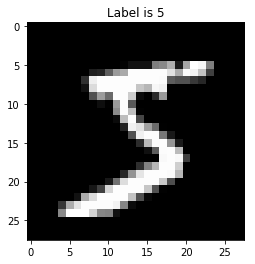

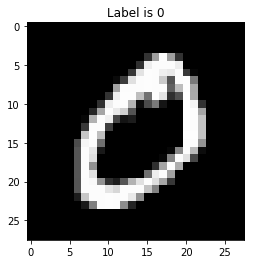

In [7]:
plot_number_image(train_images[0], train_labels[0])
plot_number_image(train_images[1], train_labels[1])

Since we want ultimately plot the images after having performed PCA on them, we don't need all the images and labels. For that reason, we will use the 1000 first images of the handwritten digits.

In [8]:
train_images_s = train_images[:1000]
train_labels_s = train_labels[:1000]

### 2. PCA with Scikit-learn 
In order to get a general idea of the result of PCA, learn how to use a powerful library and later compare it with our algorithm, we are going first to do PCA with the scikit-learn implementation.

It's very easy to use and with only 2 lines, we can have it.

In [9]:
from sklearn.decomposition import PCA

In [10]:
pca = PCA(n_components=2).fit(train_images_s)
pca_train_im = pca.transform(train_images_s)
print("Size of the train image before:  {}".format(train_images[0].shape))
print("Size of the train image after:  {}".format(pca_train_im[0].shape))

Size of the train image before:  (784,)
Size of the train image after:  (2,)


So this is PCA, an algorithm that reduces the attributes of each example of the dataset. Here we have reduced it to two dimensions so it's possible to plot it. We will discuss later how to choose the correct number of dimensions not to lose too much information in the compression.

Nevertheless, it would be great to have an visualization of the MNIST.

In [11]:
def plot_by_number_2D(images, labels):
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('Principal Component 1', fontsize = 15)
    ax.set_ylabel('Principal Component 2', fontsize = 15)
    ax.set_title('2 component PCA', fontsize = 20)
    targets = [0,1,2,3,4,5,6,7,8,9,10]
    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red',
              'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray',
              'tab:olive', 'tab:cyan']
    for target, color in zip(targets,colors):
        elements = images[np.where(labels == target)]
        ax.scatter(elements[:, 0]
                   , elements[:, 1]
                   , c = color
                   , s = 50)
    ax.legend(targets)
    ax.grid()

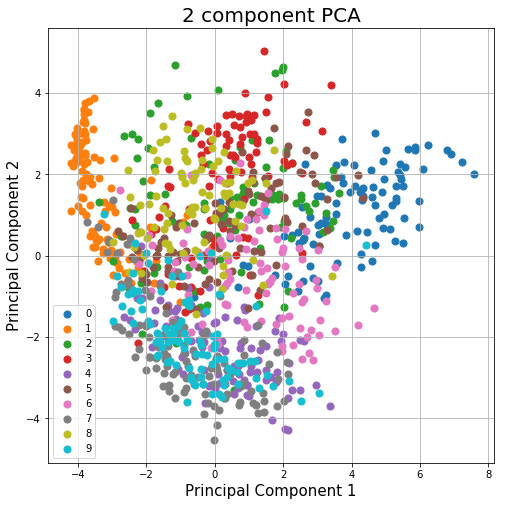

In [12]:
plot_by_number_2D(pca_train_im, train_labels_s)

It's incredible how after reducing from 784 dimensions to only 2 it's still possible to differentiate groups of images that have the same labels, like the orange cluster of '1' or the dark blue of '0'.

With this implementation, we have seen PCA in action. However, we don't know yet how it works.

### 3. PCA algorithm explained
We should define exactly what it's the objective of PCA for understanding it.
<br>Mathematically, the goal of Principal Component Analysis, or PCA, is to find a collection of $k \leq d$ unit vectors $v_i \in \mathbb{R}^{d}$ for $i \in 1,...,k$ called Principal Components, or PCs, such that the variance of the dataset projected onto the direction determined by $v_i$ is maximized and $v_i$ is chosen to be orthogonal to $v_1, ..., v_{i-1}$.

So, this translated is that we have to minimized the projection error of the Principal Component, or in other words we have to minimized $J(U,Z) = \frac{1}{n}\sum_{i=1}^{n} \|x^{(i)}-\hat{x}^{(i)}\|^2$ where $x^{(i)}$ is the real point and $\hat{x}^{(i)}$ is the reconstructed point.

<br>
For minimizing that, we have to find the Principal Components. These are find by computing the covariance matrix and later on computing the eigenvectors and eigenvalues of this matrix. 

The reason of why do we need to compute the eigenvectors and eigenvalues of the covariance matrix is because this vectors will represent the directions in which the variance is greater, and we will measure how much greater with the eigenvalue.

The covariance matrix is computed by: $\Sigma_{ij} = \mathbb{E}[(x_i-\mu_i)(x_j-\mu_j)] = \frac{1}{n-1}\sum_{ij}(x_i-\mu_i)(x_j-\mu_j) = \frac{1}{n-1}(X-\mu)(X-\mu)^T$ for $i,j = 1,...,n$ being $\Sigma_{ij}$ each entry of the matrix.

After that, we have to compute the eigenvectors and eigenvalues. This is because by computing them we can construct other matrix with the eigenvalues in the diagonal and zeros elsewhere, which would mean that, after changing the basis of the points, each attribute has zero covariance with the other attributes and later on choose those eigenvalues that retain the most variance and reducing the number of attributes.

The way of knowing which eigenvector marks the direction which preserves most variance is by computing the percentage of variance explained by itself, which is computed by $\% variance\ explained = \frac{eigenvalue_i}{\sum{eigenvalue_j}}$, and this is why eigenvalues must be ordered by its absolute value, so as to know which of the eigenvectors preserve the most variance.

The number of eigenvectors and eigenvalues chosen represents the number of final attributes we want to have. To compute the projections, it's as simple as $Z = X U_k$, where $U_k^T$ represents the k columns of the eigenvectors chosen. The reconstructed points can be computed as $X = Z U_k^T$.

In [13]:
def PCA(X, n_components):
    # normalize to zero mean
    mu = X.mean(axis=0)
    X = X - mu
    
    # eigenvectors of covariance matrix
    sigma = (1/X.shape[0])*X.T @ X
    eigvals, eigvecs = np.linalg.eig(sigma)
    
    # principal components
    order = np.argsort(eigvals)[::-1]
    components = eigvecs[:, order[:n_components]]
    
    # projection
    Z = X @ components
    
    # result
    return Z, components, eigvals[order]

In [14]:
Z, components, order = PCA(train_images_s, 2)

Variance retained: 0.17687608301639557


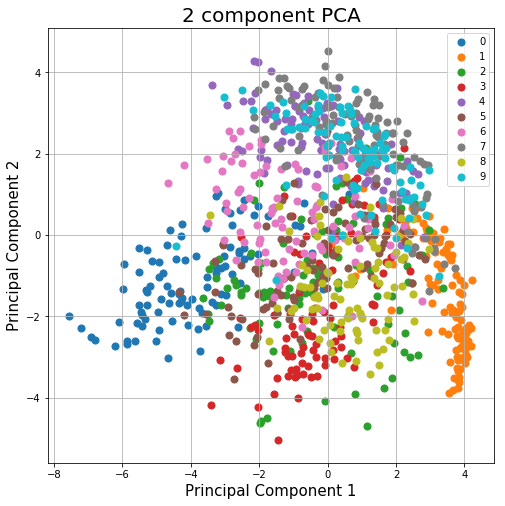

In [15]:
plot_by_number_2D(Z, train_labels_s)
print("Variance retained: {}".format((order[:2].sum())/order.sum()))

As we can see, we obtain the same plot that we got with the scikit-learn but upside down, this is because our 2-coordinates are multiplied by -1 due to the fact that eigenvalues can be positive or negative. We can also see how we have achieved to retain a $17.69 \%$ of variance with 2-dimensions.

<br>
It's also possible to plot the variance retained with different dimensions. This could help us see how many dimensions we could choose so as not to lose to much information.

In [16]:
number_dim = np.arange(1, order.shape[0]+1)
variance_retained = np.array([(order[:i].sum())/order.sum() for i in number_dim])

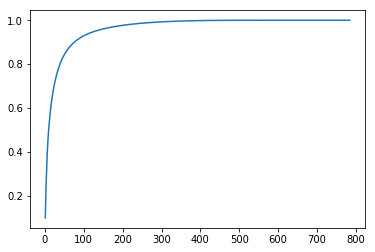

In [17]:
plt.plot(number_dim, variance_retained)

With this plot and following the elbow method, it's easy to choose the number of dimensions. This rule says that the number of dimensions should be where the plot starts to curve rapidly, here it would be around 100.
<br>
With all this implementations, it's also possible to show another application of PCA, not only to plot the images, but also it's possible to reconstruct them, by the formula given in the previous paragraph.

In [18]:
def plot_reconstructed_by_dimensions(list_of_dimensions, images, labels, index):
    number = len(list_of_dimensions)
    for c, dimensions in enumerate(list_of_dimensions,1):
        Z, components, order = PCA(images, dimensions)
        pixels = (Z @ components.T)[index].reshape((28, 28))
        plt.subplot(number//5, 5, c)
        plt.imshow(pixels, cmap='gray')
        plt.title('Dim {}'.format(dimensions))
        
    plt.suptitle("Real Number: {}".format(labels[index]))

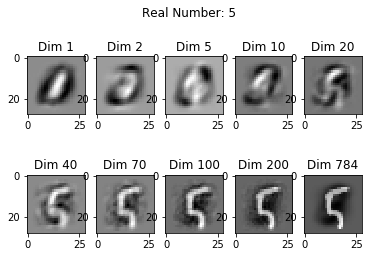

In [19]:
list_of_dimensions = [1,2,5,10,20,40,70,100,200,784]
plot_reconstructed_by_dimensions(list_of_dimensions, train_images_s, train_labels, 100)

Reference: 
1. https://mattpetersen.github.io/load-mnist-with-numpy
2. https://medium.com/100-days-of-algorithms/day-92-pca-bdb66840a8fb
3. https://en.wikipedia.org/wiki/Principal_component_analysis
4. http://mengnote.blogspot.com/2013/05/an-intuitive-explanation-of-pca.html
5. https://intoli.com/blog/pca-and-svd/
6. https://stats.stackexchange.com/questions/2691/making-sense-of-principal-component-analysis-eigenvectors-eigenvalues
7. https://es.coursera.org/learn/machine-learning
8. https://en.wikipedia.org/wiki/Elbow_method_(clustering)
9. https://matplotlib.org/api/
10. https://docs.scipy.org/doc/numpy/
